In [1]:
import numpy as np
import matplotlib.pyplot as plt
from napari_flim_phasor_plotter import _synthetic as syn
from scipy.stats import norm
from scipy import signal

## Generate synthetic image 3D data for initial run

### Generation functions

In [2]:
def calculate_exp(x, A, tau):
    import numpy as np
    if np.isscalar(tau):
        tau = np.array([tau])
        A = np.array([A])
    return np.sum(A[:, None] * np.exp(-1/tau[:, None]*x), axis = 0)

def create_synthetic_decay(number_of_output_time_points, amplitudes, life_times, laser_frequency = 40, max_photon_count = 2000, offset = 0.3, irf_fwhm = 0.1, round_to_int = False):
    import numpy as np
    from scipy.stats import norm
    from scipy.signal import convolve
    from napari_flim_phasor_plotter import _synthetic as syn

    ratio = int(np.rint(10000/number_of_output_time_points))
    number_of_time_points = ratio * number_of_output_time_points
    smooth_time = syn.create_time_array(laser_frequency,number_of_time_points)
    smooth_decay = calculate_exp(smooth_time, amplitudes, life_times)
    smooth_irf = norm.pdf(smooth_time, loc = offset, scale = irf_fwhm)
    smooth_irf = smooth_irf[smooth_irf>0]
    smooth_irf /= np.max(smooth_irf)
    smooth_convolved = convolve(smooth_decay, smooth_irf, mode = "full", method = "direct")
    descaled_convolution = smooth_convolved[::ratio][:number_of_output_time_points]
    descaled_convolution /= np.max(descaled_convolution)
    if round_to_int:
        return(np.rint(descaled_convolution).astype("int"))
    else:
        return(descaled_convolution)

    
def generate_random_coordinates(image_size, num_points, seed=7):
    import numpy as np
    
    coordinates = set()  # Use a set to store unique coordinates
    np.random.seed(seed)
    while len(coordinates) < num_points:
        x = np.random.randint(image_size[1]/3, 2*image_size[1]/3)
        y = np.random.randint(image_size[0]/3, 2*image_size[0]/3)
        coordinates.add((x, y))
    
    return list(coordinates)

def create_circle_mask(image_size, center_coordinate, radius):
    import numpy as np

    mask = np.zeros(image_size, dtype=bool)
    image_grid = np.ogrid[:image_size[1], :image_size[0]]
    distance =  np.linalg.norm(np.asarray(image_grid, dtype=object)-np.asarray(center_coordinate, dtype=object))
    mask[distance <= radius] = True
    return(mask)

def add_lifetime_via_mask(image_size, mask, tcspc_array, max_photon_count = 2000, bg_counts = 0):
    import numpy as np

    processed_image = np.zeros((len(tcspc_array), image_size[0], image_size[1]))
    for x,y in np.transpose(mask.nonzero()):
        processed_image[:,x,y] = np.random.poisson(max_photon_count * tcspc_array) + bg_counts
    
    masked_points = processed_image[:,mask]
    return(masked_points)

### Created images

In [3]:
image_size = (100,100)
num_points = 3

coordinates = generate_random_coordinates(image_size, num_points)
radius1 = np.linalg.norm(np.asarray(coordinates[0])-np.asarray(coordinates[2]))
radius2 = np.linalg.norm(np.asarray(coordinates[1])-np.asarray(coordinates[2]))

mask1 = create_circle_mask(image_size, coordinates[0], radius1)
mask2 = create_circle_mask(image_size, coordinates[1], radius2)

intersection = np.logical_and(mask1,mask2)
circle1 = np.logical_and(mask1,np.logical_not(intersection))
circle2 = np.logical_and(mask2,np.logical_not(intersection))

In [4]:
laser_frequency = 40 # MHz
number_of_time_points = 256#common for FLIM images
sigma = 0.2
offset = 3 * sigma

time = syn.create_time_array(laser_frequency, number_of_time_points)
tau_1 = 0.7
tau_2 = 2
amplitude=1
a1 = 0.6
two_amplitudes = np.array([a1, 1-a1])
tau_array = np.array([tau_1,tau_2])


conv_counts_tau1 = create_synthetic_decay(number_of_time_points, 1, tau_1, offset = offset, irf_fwhm = sigma)
conv_counts_tau2 = create_synthetic_decay(number_of_time_points, 1, tau_2, offset = offset, irf_fwhm = sigma)
conv_counts_mixed = create_synthetic_decay(number_of_time_points, two_amplitudes, tau_array, offset = offset, irf_fwhm = sigma)

In [5]:
time_image = np.ones((len(conv_counts_tau1), image_size[0], image_size[1]))

time_image[:, circle1] = add_lifetime_via_mask(image_size, circle1, conv_counts_tau1)
time_image[:, intersection] = add_lifetime_via_mask(image_size, intersection, conv_counts_mixed)
time_image[:, circle2] = add_lifetime_via_mask(image_size, circle2, conv_counts_tau2)

/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


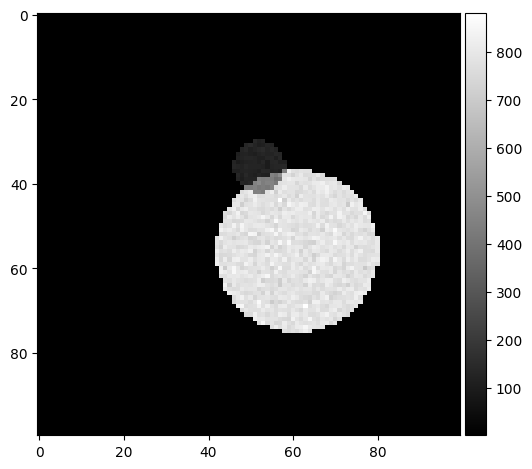

In [6]:
from skimage import io

io.imshow(time_image[30],cmap=plt.cm.gray)

In [59]:
import napari
viewer = napari.Viewer()

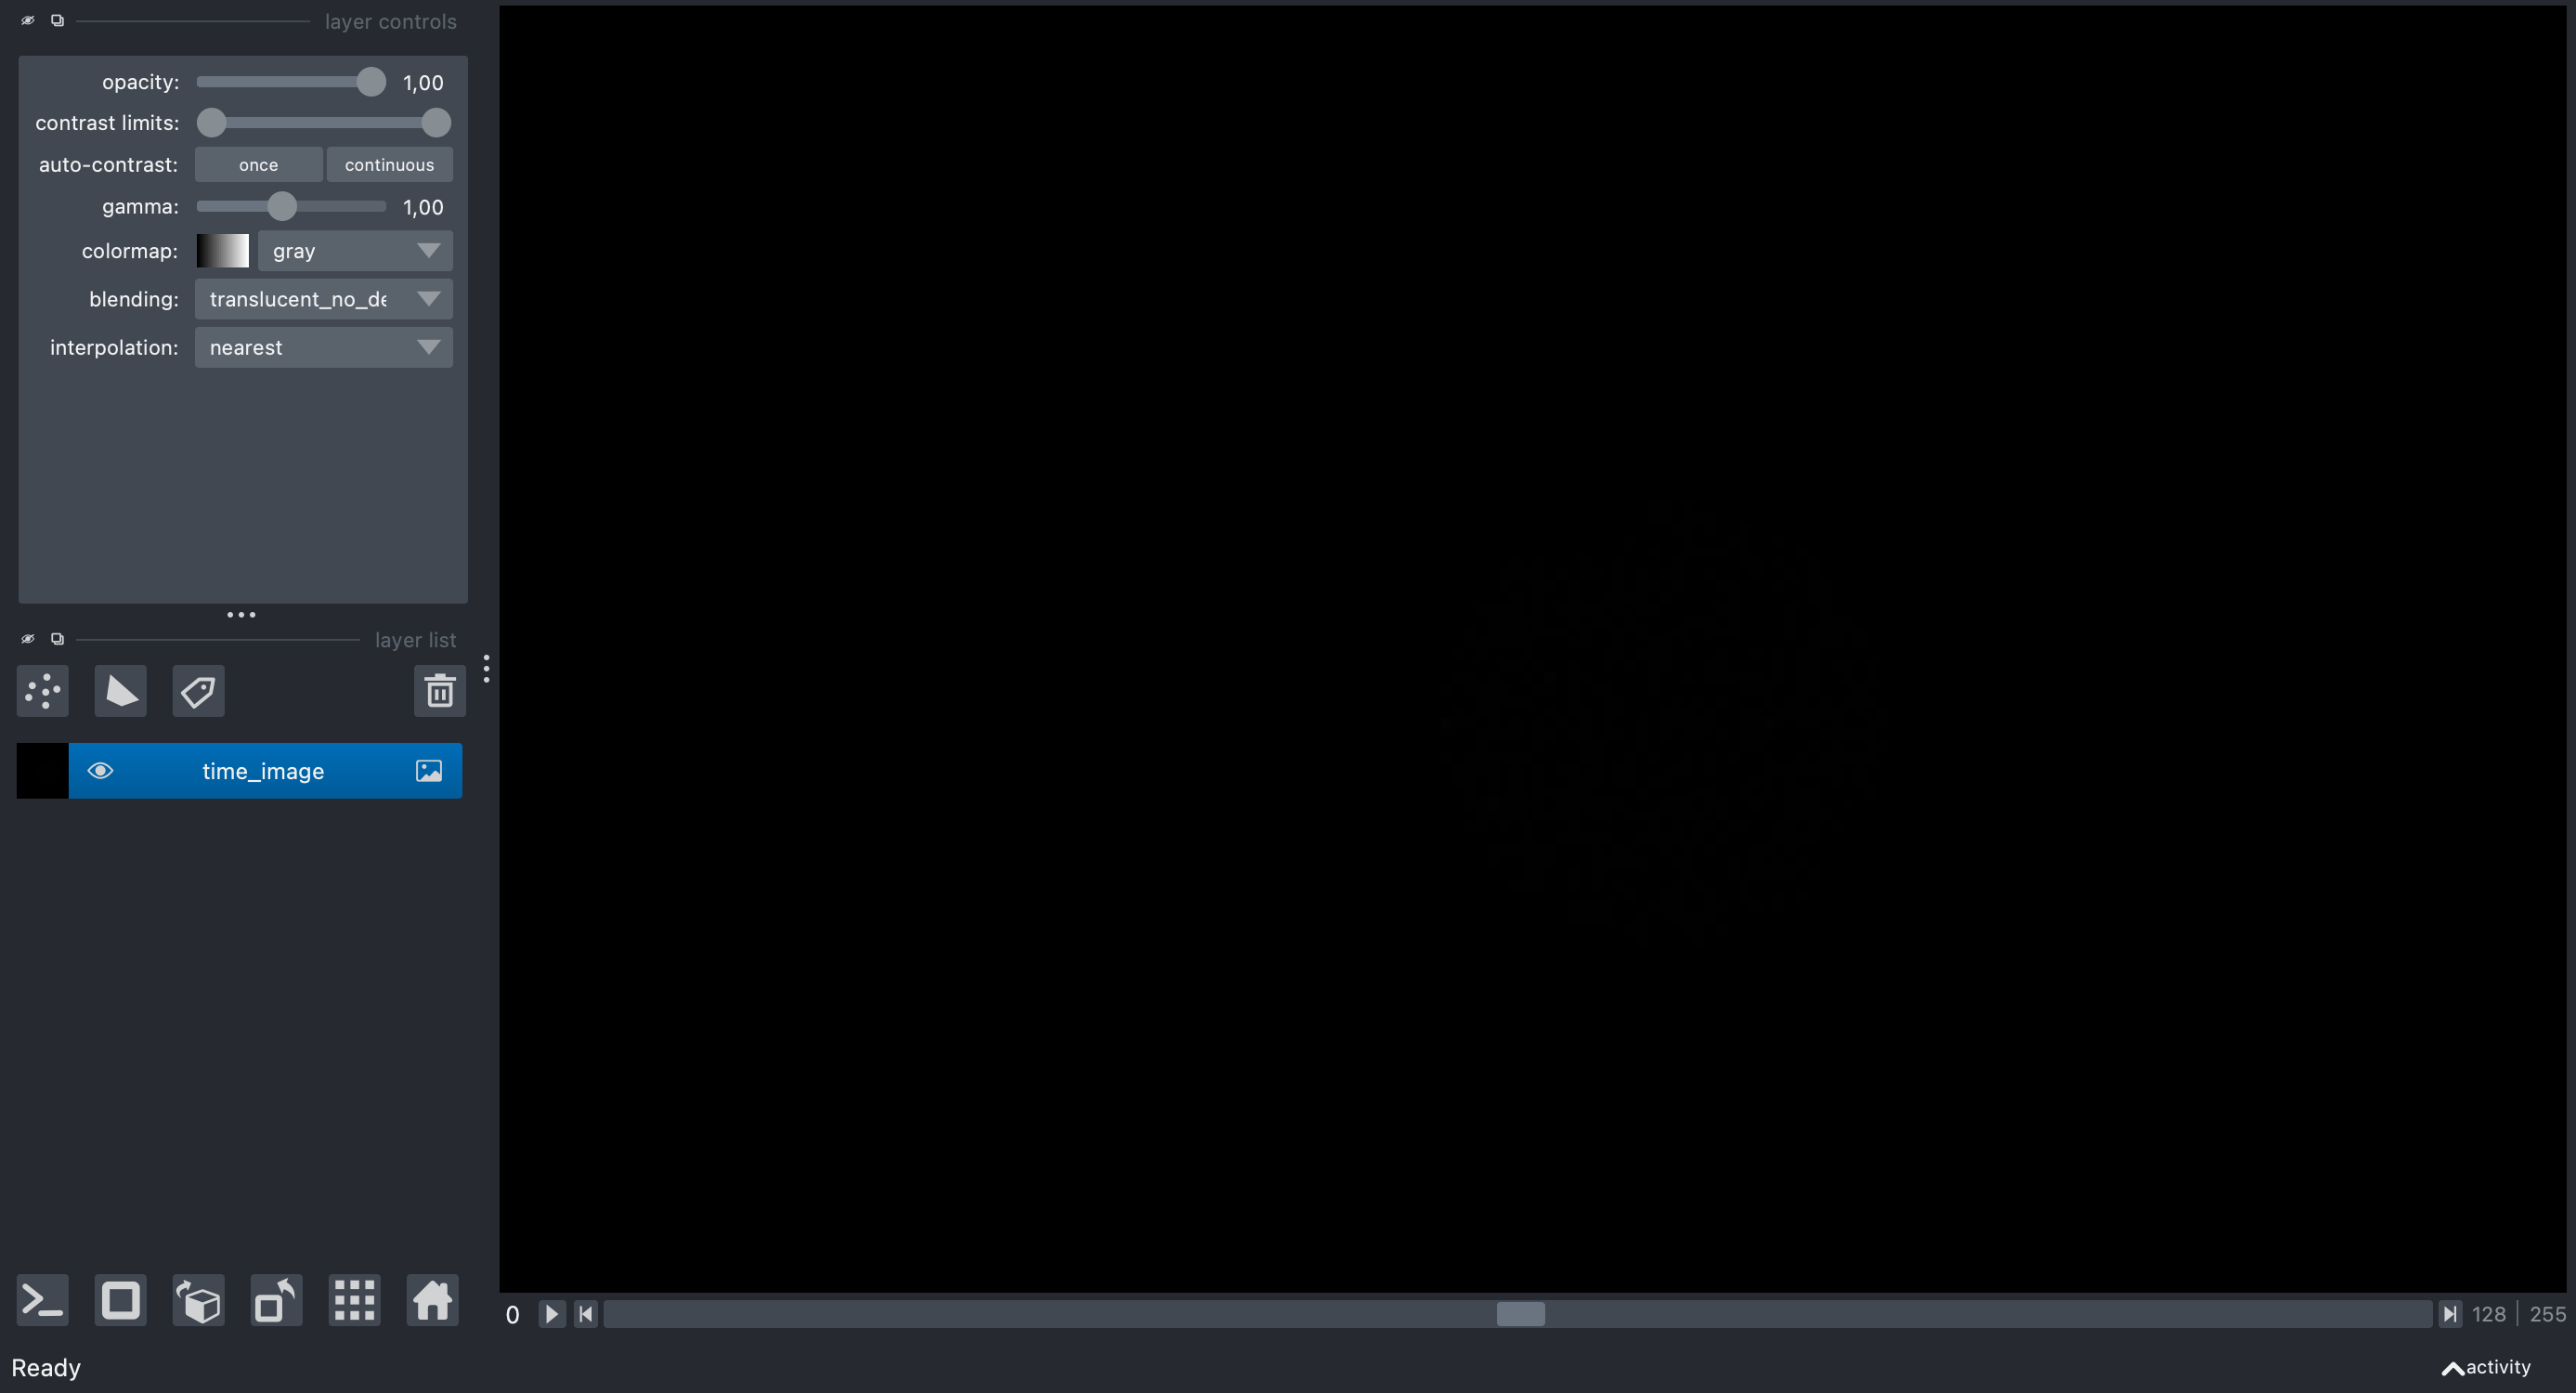

In [60]:
viewer.add_image(time_image)
napari.utils.nbscreenshot(viewer)

## Calculations for single pixel

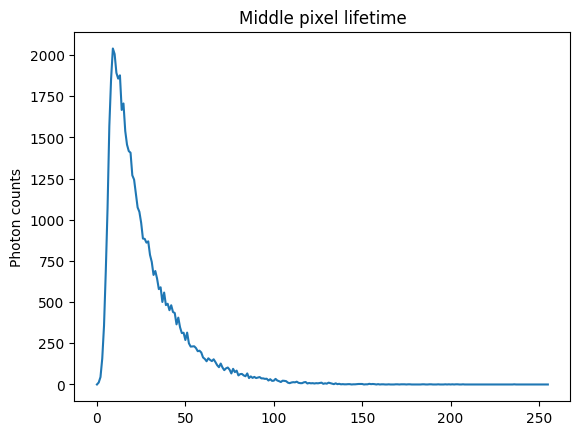

In [12]:
plt.plot(time_image[:,50,50])
plt.title("Middle pixel lifetime")
plt.ylabel("Photon counts")
plt.show()

In [7]:
def reconstruct_irf(tcspc_array):
    import numpy as np

    derive_irf = np.diff(tcspc_array)
    if np.argmax(derive_irf) == 0:
        return(derive_irf)
    else: 
        derive_irf  = derive_irf[:(np.argmax(derive_irf)+1)]
        derive_irf = np.concatenate((derive_irf, derive_irf[::-1][1:]))
        derive_irf /= np.max(derive_irf)
        return(derive_irf)

def get_deconvolved_decay(tcspc_array, irf, n_iterations = 50):
    import numpy as np
    from skimage.restoration import richardson_lucy
    max_photon_counts = np.max(tcspc_array)
    exp_decay = richardson_lucy(image = tcspc_array/max_photon_counts, psf = irf , num_iter = n_iterations)
    exp_maximums = (exp_decay == np.max(exp_decay)).nonzero()[0]
    exp_decay = max_photon_counts * exp_decay[exp_maximums[-1]:]
    exp_decay = np.concatenate((exp_decay,tcspc_array[len(exp_decay):]))
    
    return(exp_decay)

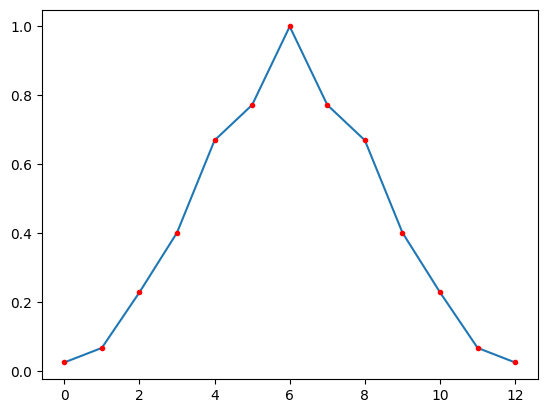

In [30]:
derive_pixel_irf = reconstruct_irf(time_image[:,50,50])
plt.plot(reconstruct_irf(time_image[:,50,50]) , '.-', mfc='red', mec = 'red')

In [50]:
np.median(np.diff(time_image[:,5,5]))

0.0

In [52]:
derive_pixel_irf = reconstruct_irf(time_image[:,5,5])

len(derive_pixel_irf)

255

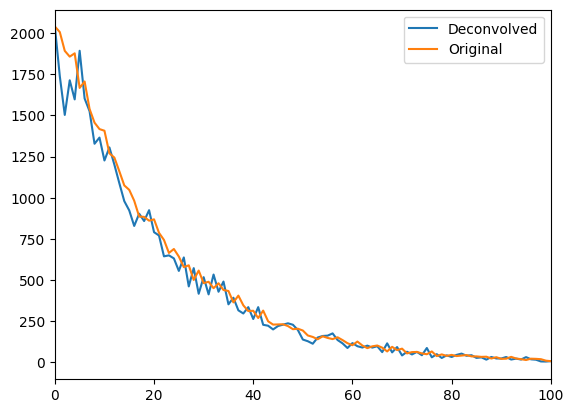

In [31]:
d_exp_decay = get_deconvolved_decay(tcspc_array = time_image[:,50,50], irf = derive_pixel_irf, n_iterations = 50)

plt.plot(d_exp_decay , label = "Deconvolved")
plt.plot(time_image[:,50,50][np.argmax(time_image[:,50,50]):], label = "Original")
plt.xlim(left = 0,right = 100)
plt.legend()

## Calculations for the whole image

In [37]:
np.zeros(time_image.shape)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [70]:
deconvolved_image = np.copy(time_image)
for x,y in np.ndindex(time_image.shape[1],time_image.shape[2]):
    time_array = time_image[:,x,y]
    derived_irf = reconstruct_irf(time_array)

    if np.sum(derived_irf) == 0:
        continue
    else:
        deconvolved_image[:,x,y] = get_deconvolved_decay(tcspc_array = time_array, irf = derived_irf, n_iterations = 50)
    

In [94]:
viewer.add_image(deconvolved_image )

<Image layer 'deconvolved_image [1]' at 0x7fd3a8a11ee0>

/Users/lana/Documents/GitHub/napari-flim-phasor-plotter/src/napari_flim_phasor_plotter/_widget.py:122: FutureWarning: Private attribute access ('Window._dock_widgets') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  value in napari_viewer.window._dock_widgets.items()]
/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/napari_clusters_plotter/_plotter_utilities.py:261: RuntimeWarning: divide by zero encountered in double_scalars
  est_a = (np.max(data) - np.min(data)) / (2 * stats.iqr(data) / np.cbrt(len(data)))
Traceback (most recent call last):
  File "/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/psygnal/_signal.py", line 972, in _run_emit_loop
    caller.cb(args)
  File "/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/psygnal/_weak_callback.py", line 268, in cb
    self._f(*self._args, *args, **self._kwargs)
  File

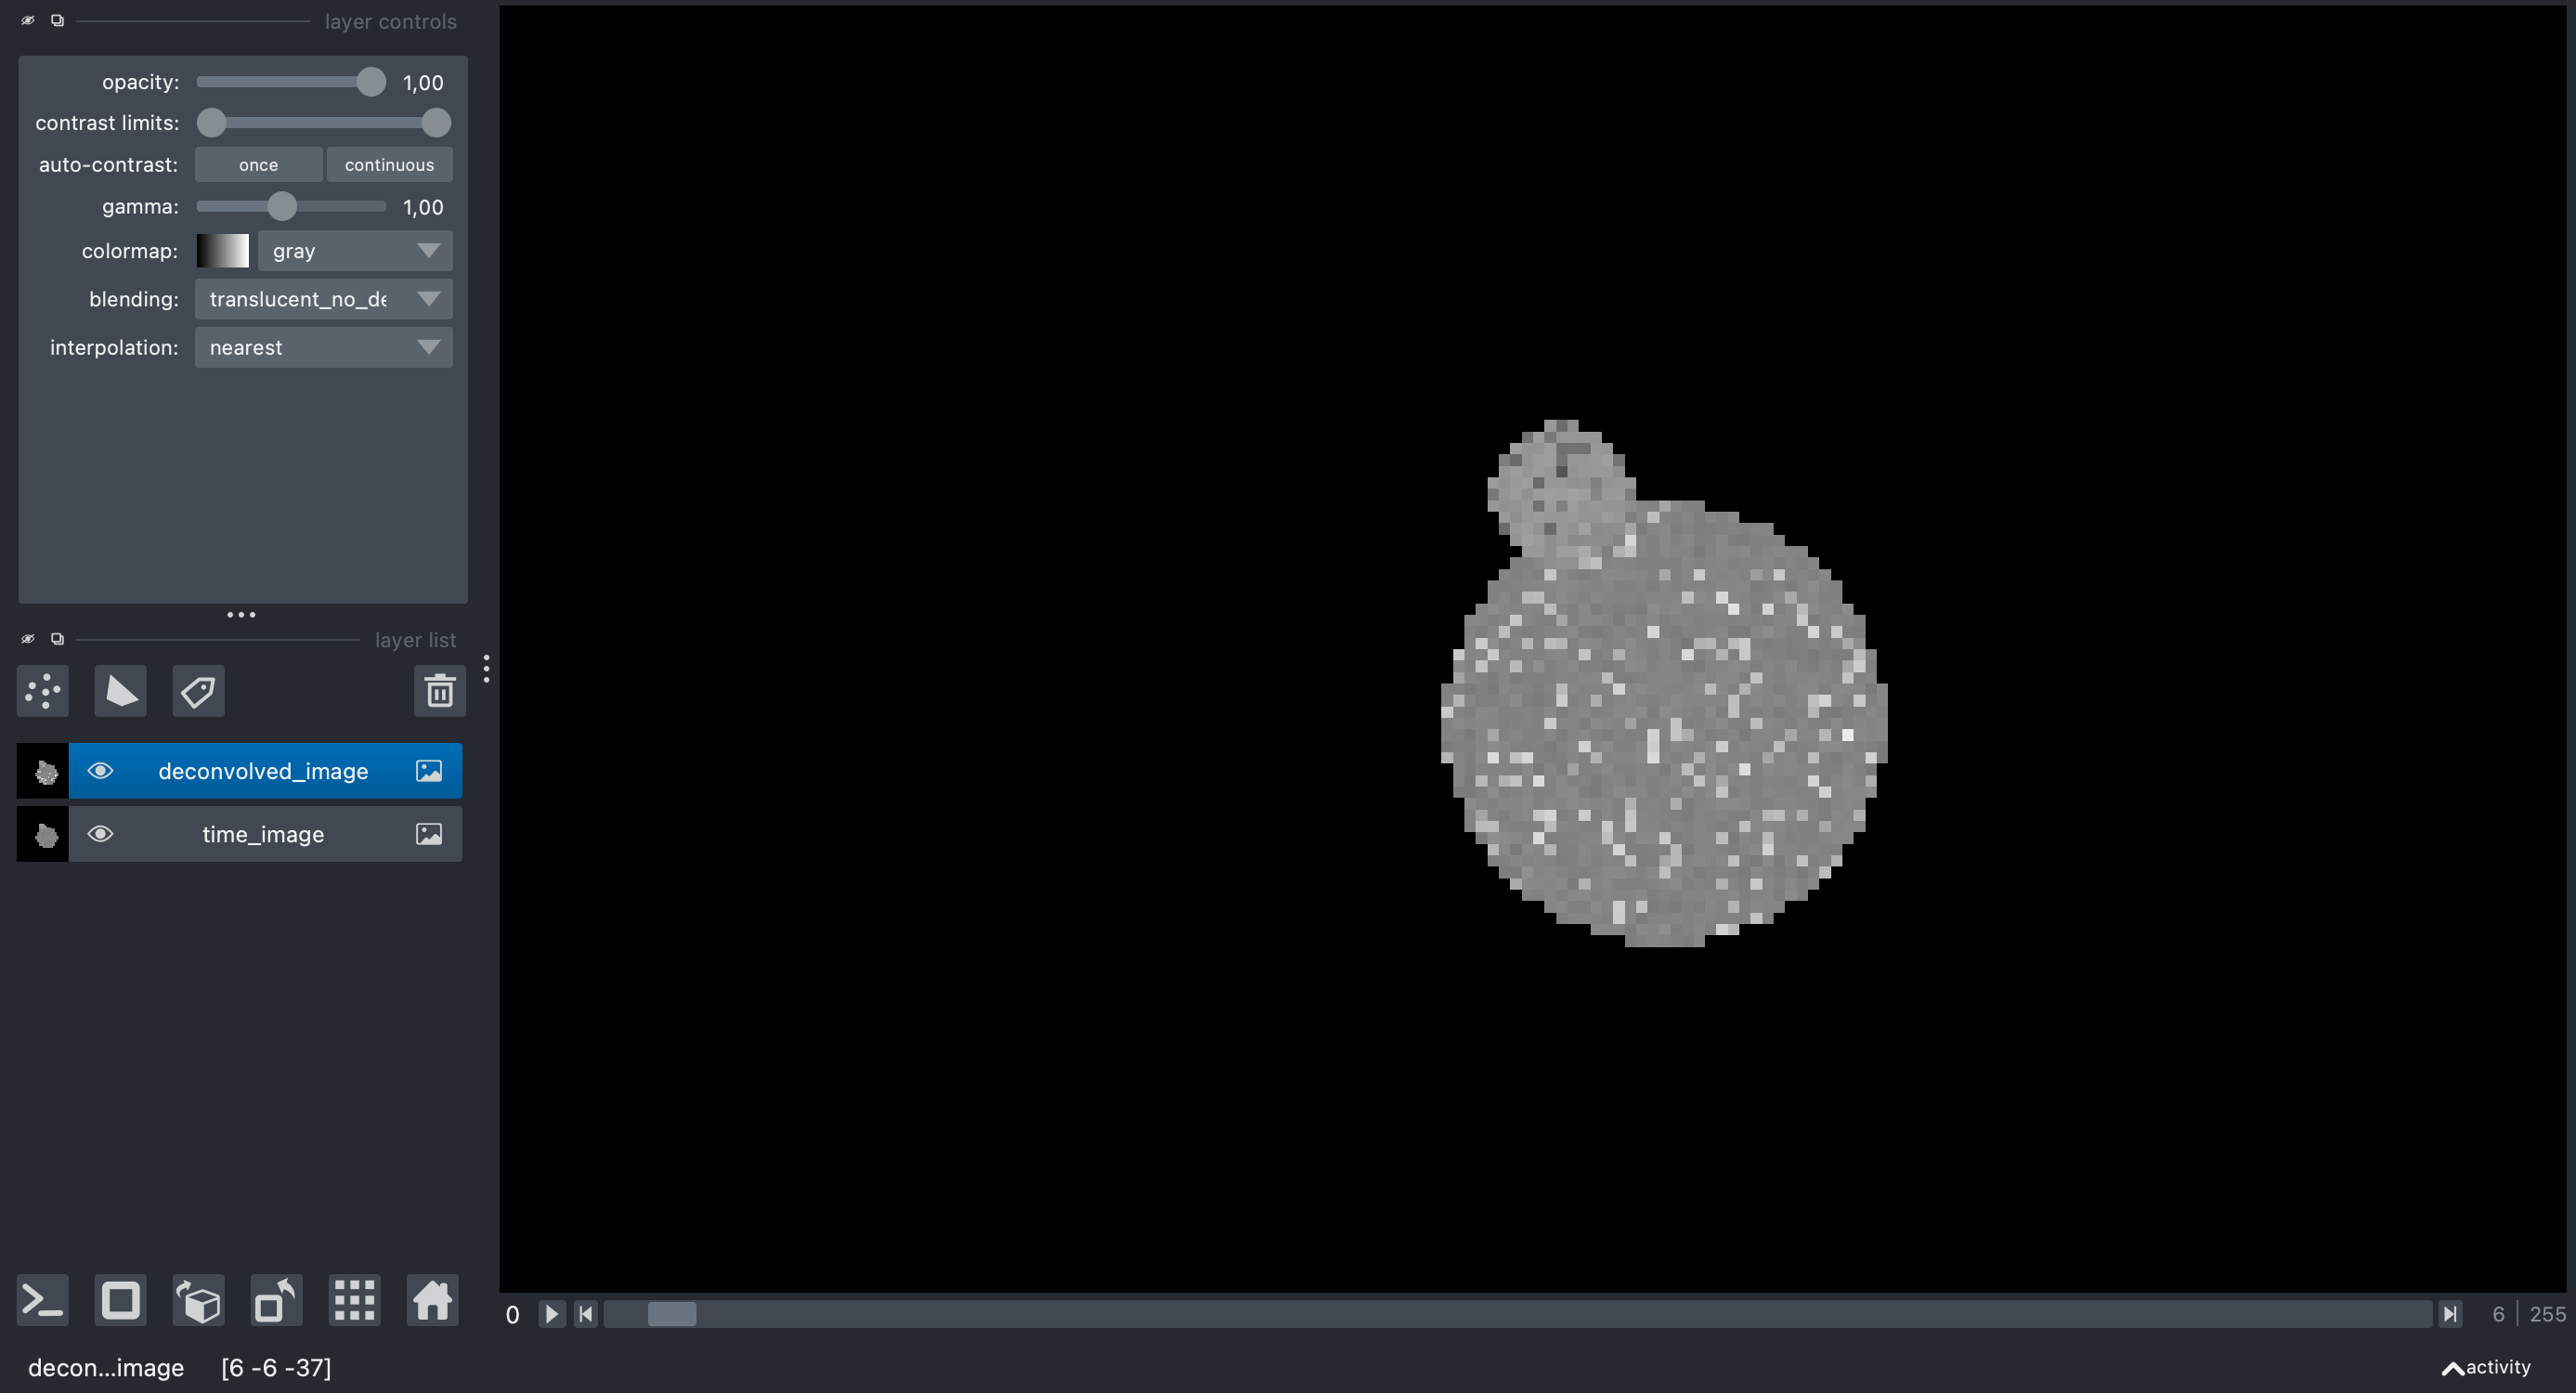

In [71]:
napari.utils.nbscreenshot(viewer)

I see weird processed pixels. others are not... why??

Looking at single pixels

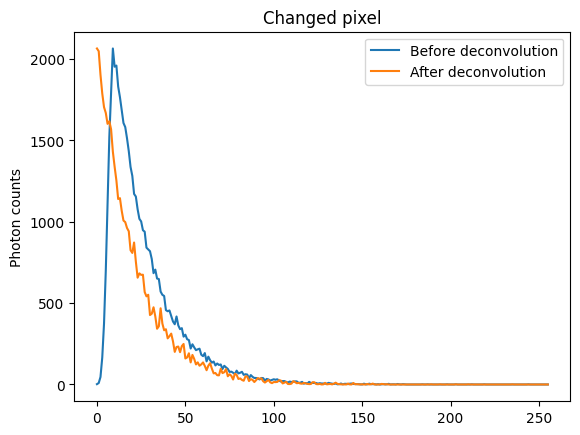

In [78]:
plt.plot(time_image[:,41,58], label = "Before deconvolution")
plt.plot(deconvolved_image[:,41,58], label = "After deconvolution")
plt.title("Changed pixel")
plt.ylabel("Photon counts")
plt.legend()
plt.show()

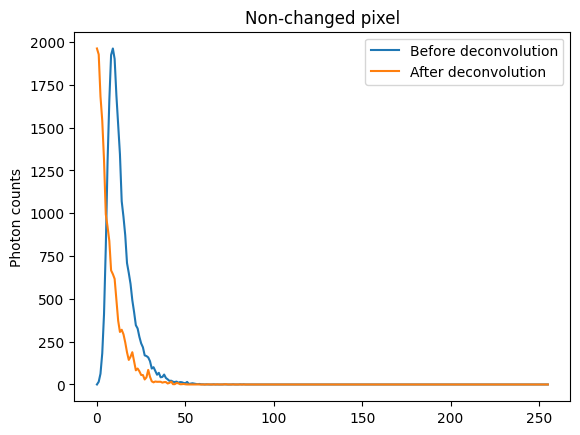

In [93]:
plt.plot(time_image[:,40,50], label = "Before deconvolution")
plt.plot(deconvolved_image[:,40,50], label = "After deconvolution")
plt.title("Non-changed pixel")
plt.ylabel("Photon counts")
plt.legend()
plt.show()

In [90]:
test_pixel = np.copy(time_image[:,40,50])

reconstruct_irf(test_pixel)

np.argmax(reconstruct_irf(time_image[:,1,1]))

0

In [8]:
deconvolved_image = np.copy(time_image)
for x,y in np.ndindex(time_image.shape[1],time_image.shape[2]):
    time_array = np.copy(time_image[:,x,y])
    derived_irf = reconstruct_irf(time_array)

    if np.sum(derived_irf) != 0:
        deconvolved_image[:,x,y] = get_deconvolved_decay(tcspc_array = time_array, irf = derived_irf, n_iterations = 50)
    else:
        continue
    

Issue solved!!! Had to change the diff selection (if maximum is at 0 index i pass)

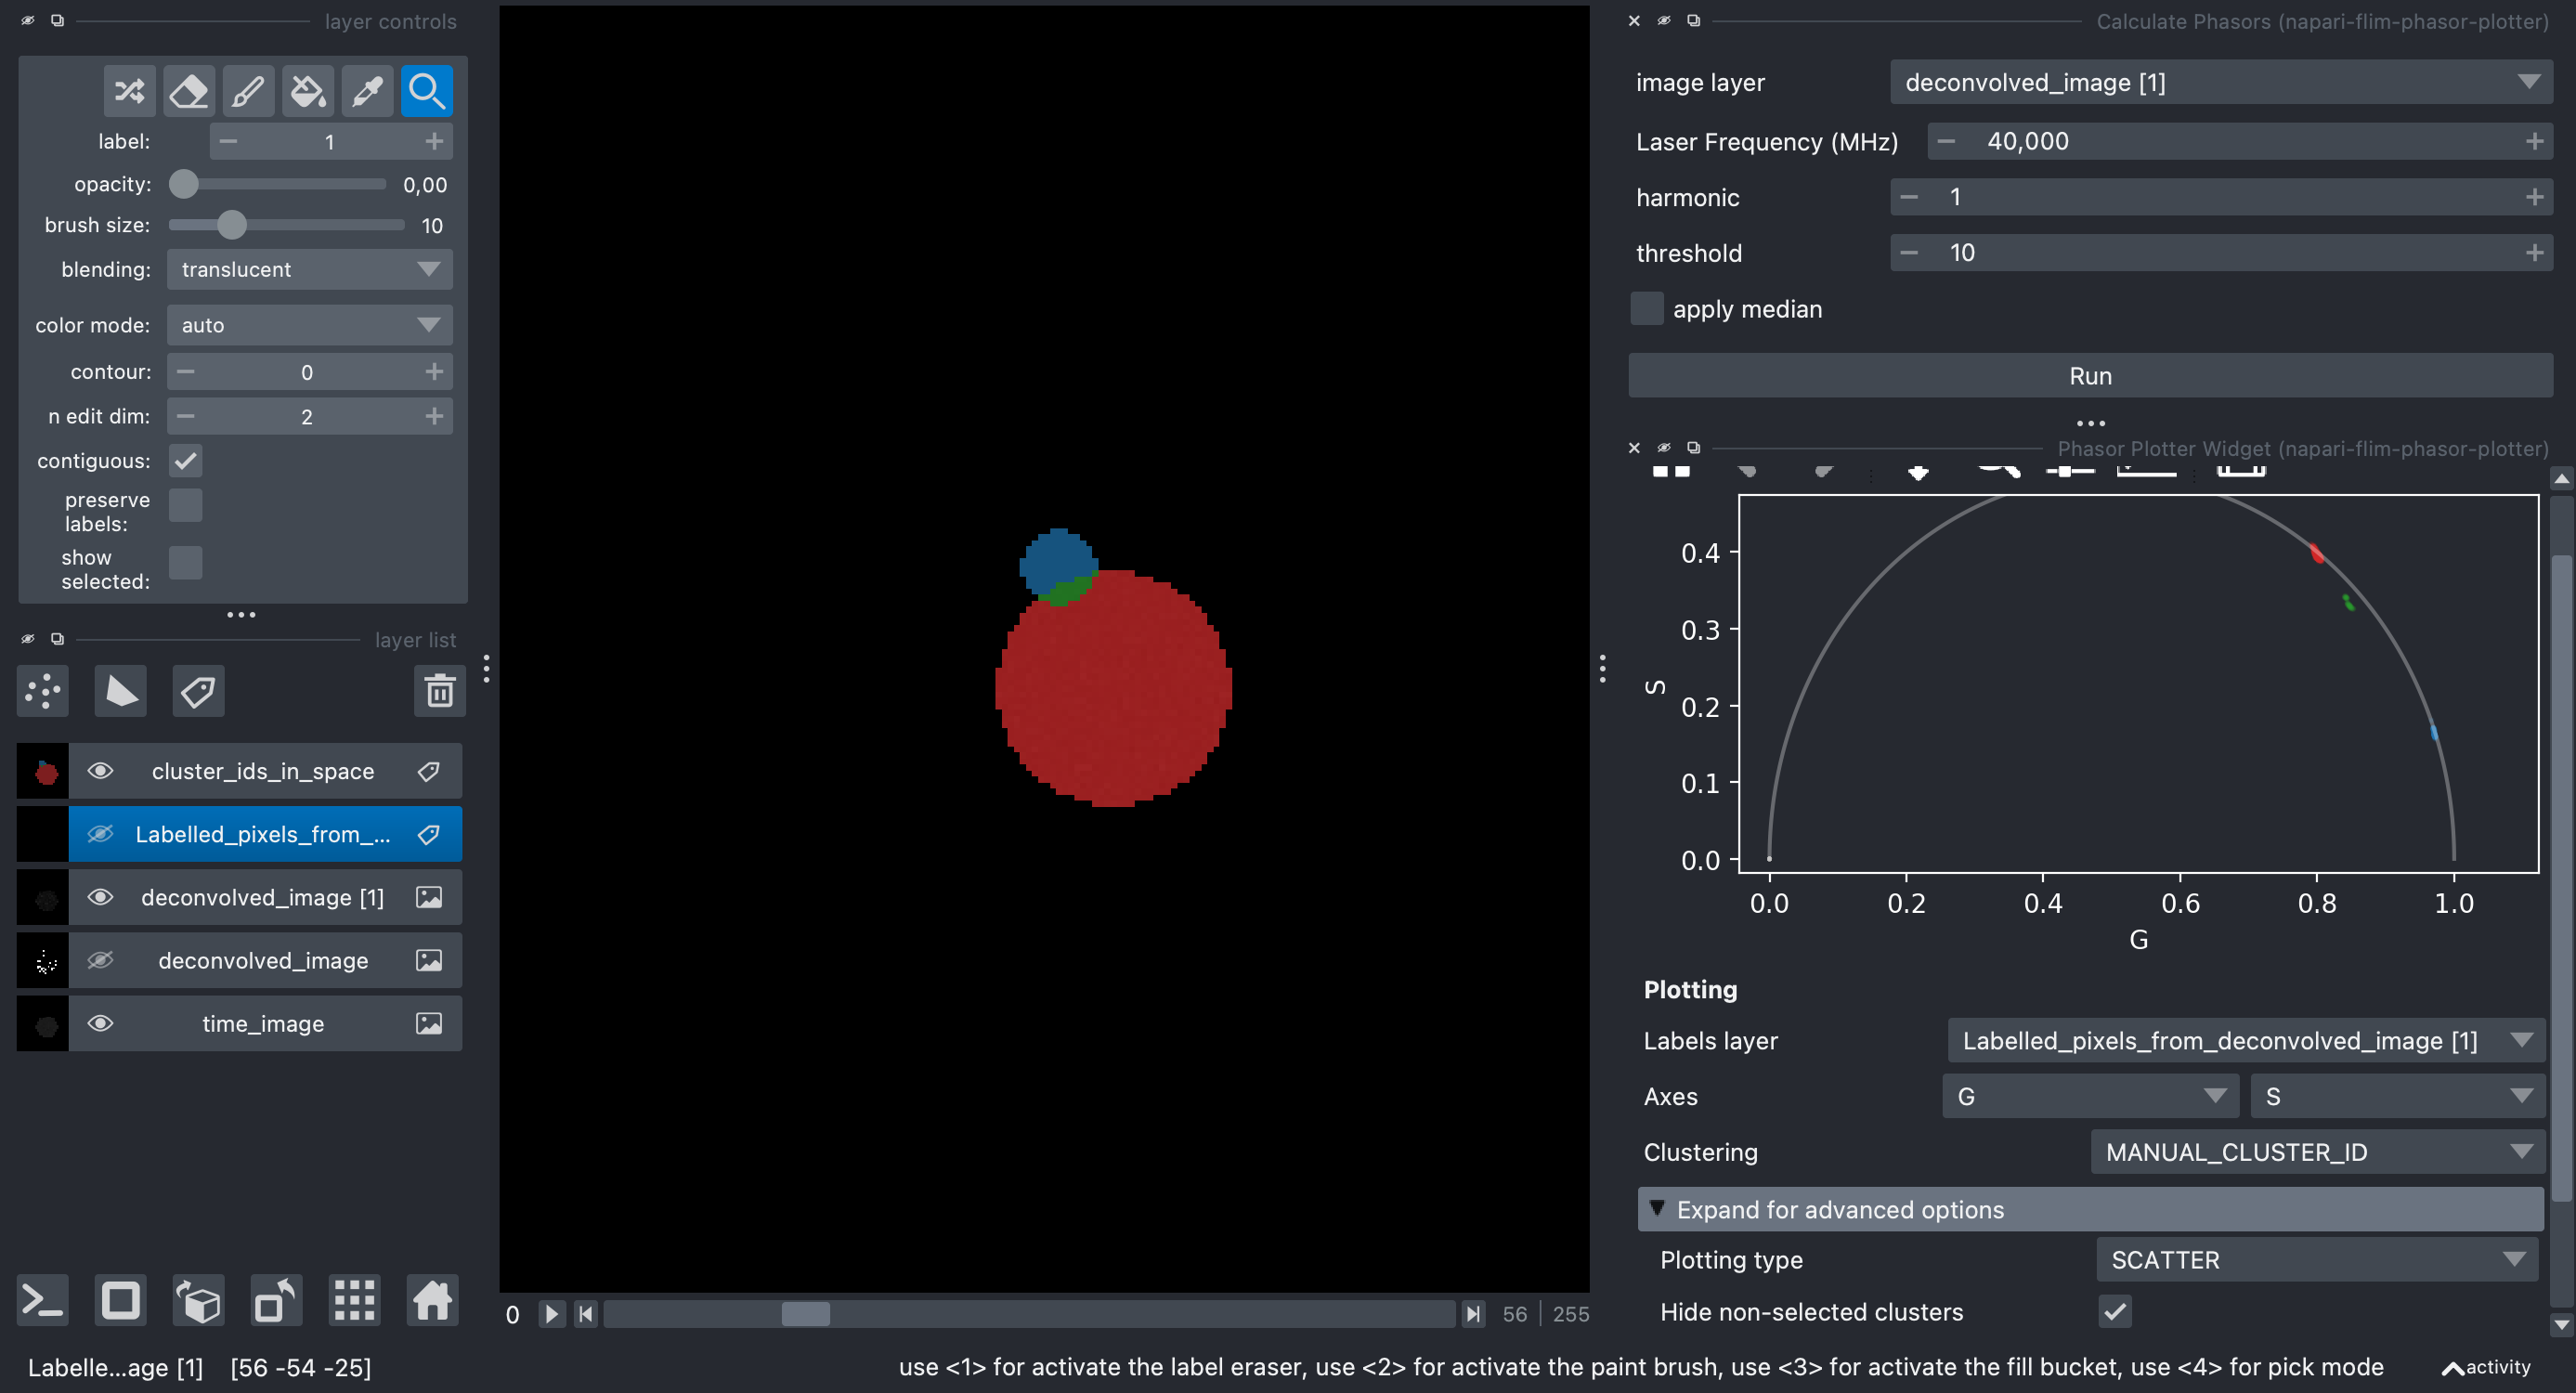

/Users/lana/Documents/GitHub/napari-flim-phasor-plotter/src/napari_flim_phasor_plotter/_widget.py:122: FutureWarning: Private attribute access ('Window._dock_widgets') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  value in napari_viewer.window._dock_widgets.items()]
/Users/lana/Documents/GitHub/napari-flim-phasor-plotter/src/napari_flim_phasor_plotter/_widget.py:128: FutureWarning: Private attribute access ('Window._dock_widgets') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  widgets = napari_viewer.window._dock_widgets['Phasor Plotter Widget (napari-flim-phasor-plotter)']
/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/napari_clusters_plotter/_plotter_utilities.py:261: RuntimeWarning: divide by zero encountered in double_scalars
  est_a = (np.max(data) - np.min(data)) / (2 * stats.iqr(data) / np.cbrt(len(data)

In [95]:
napari.utils.nbscreenshot(viewer)

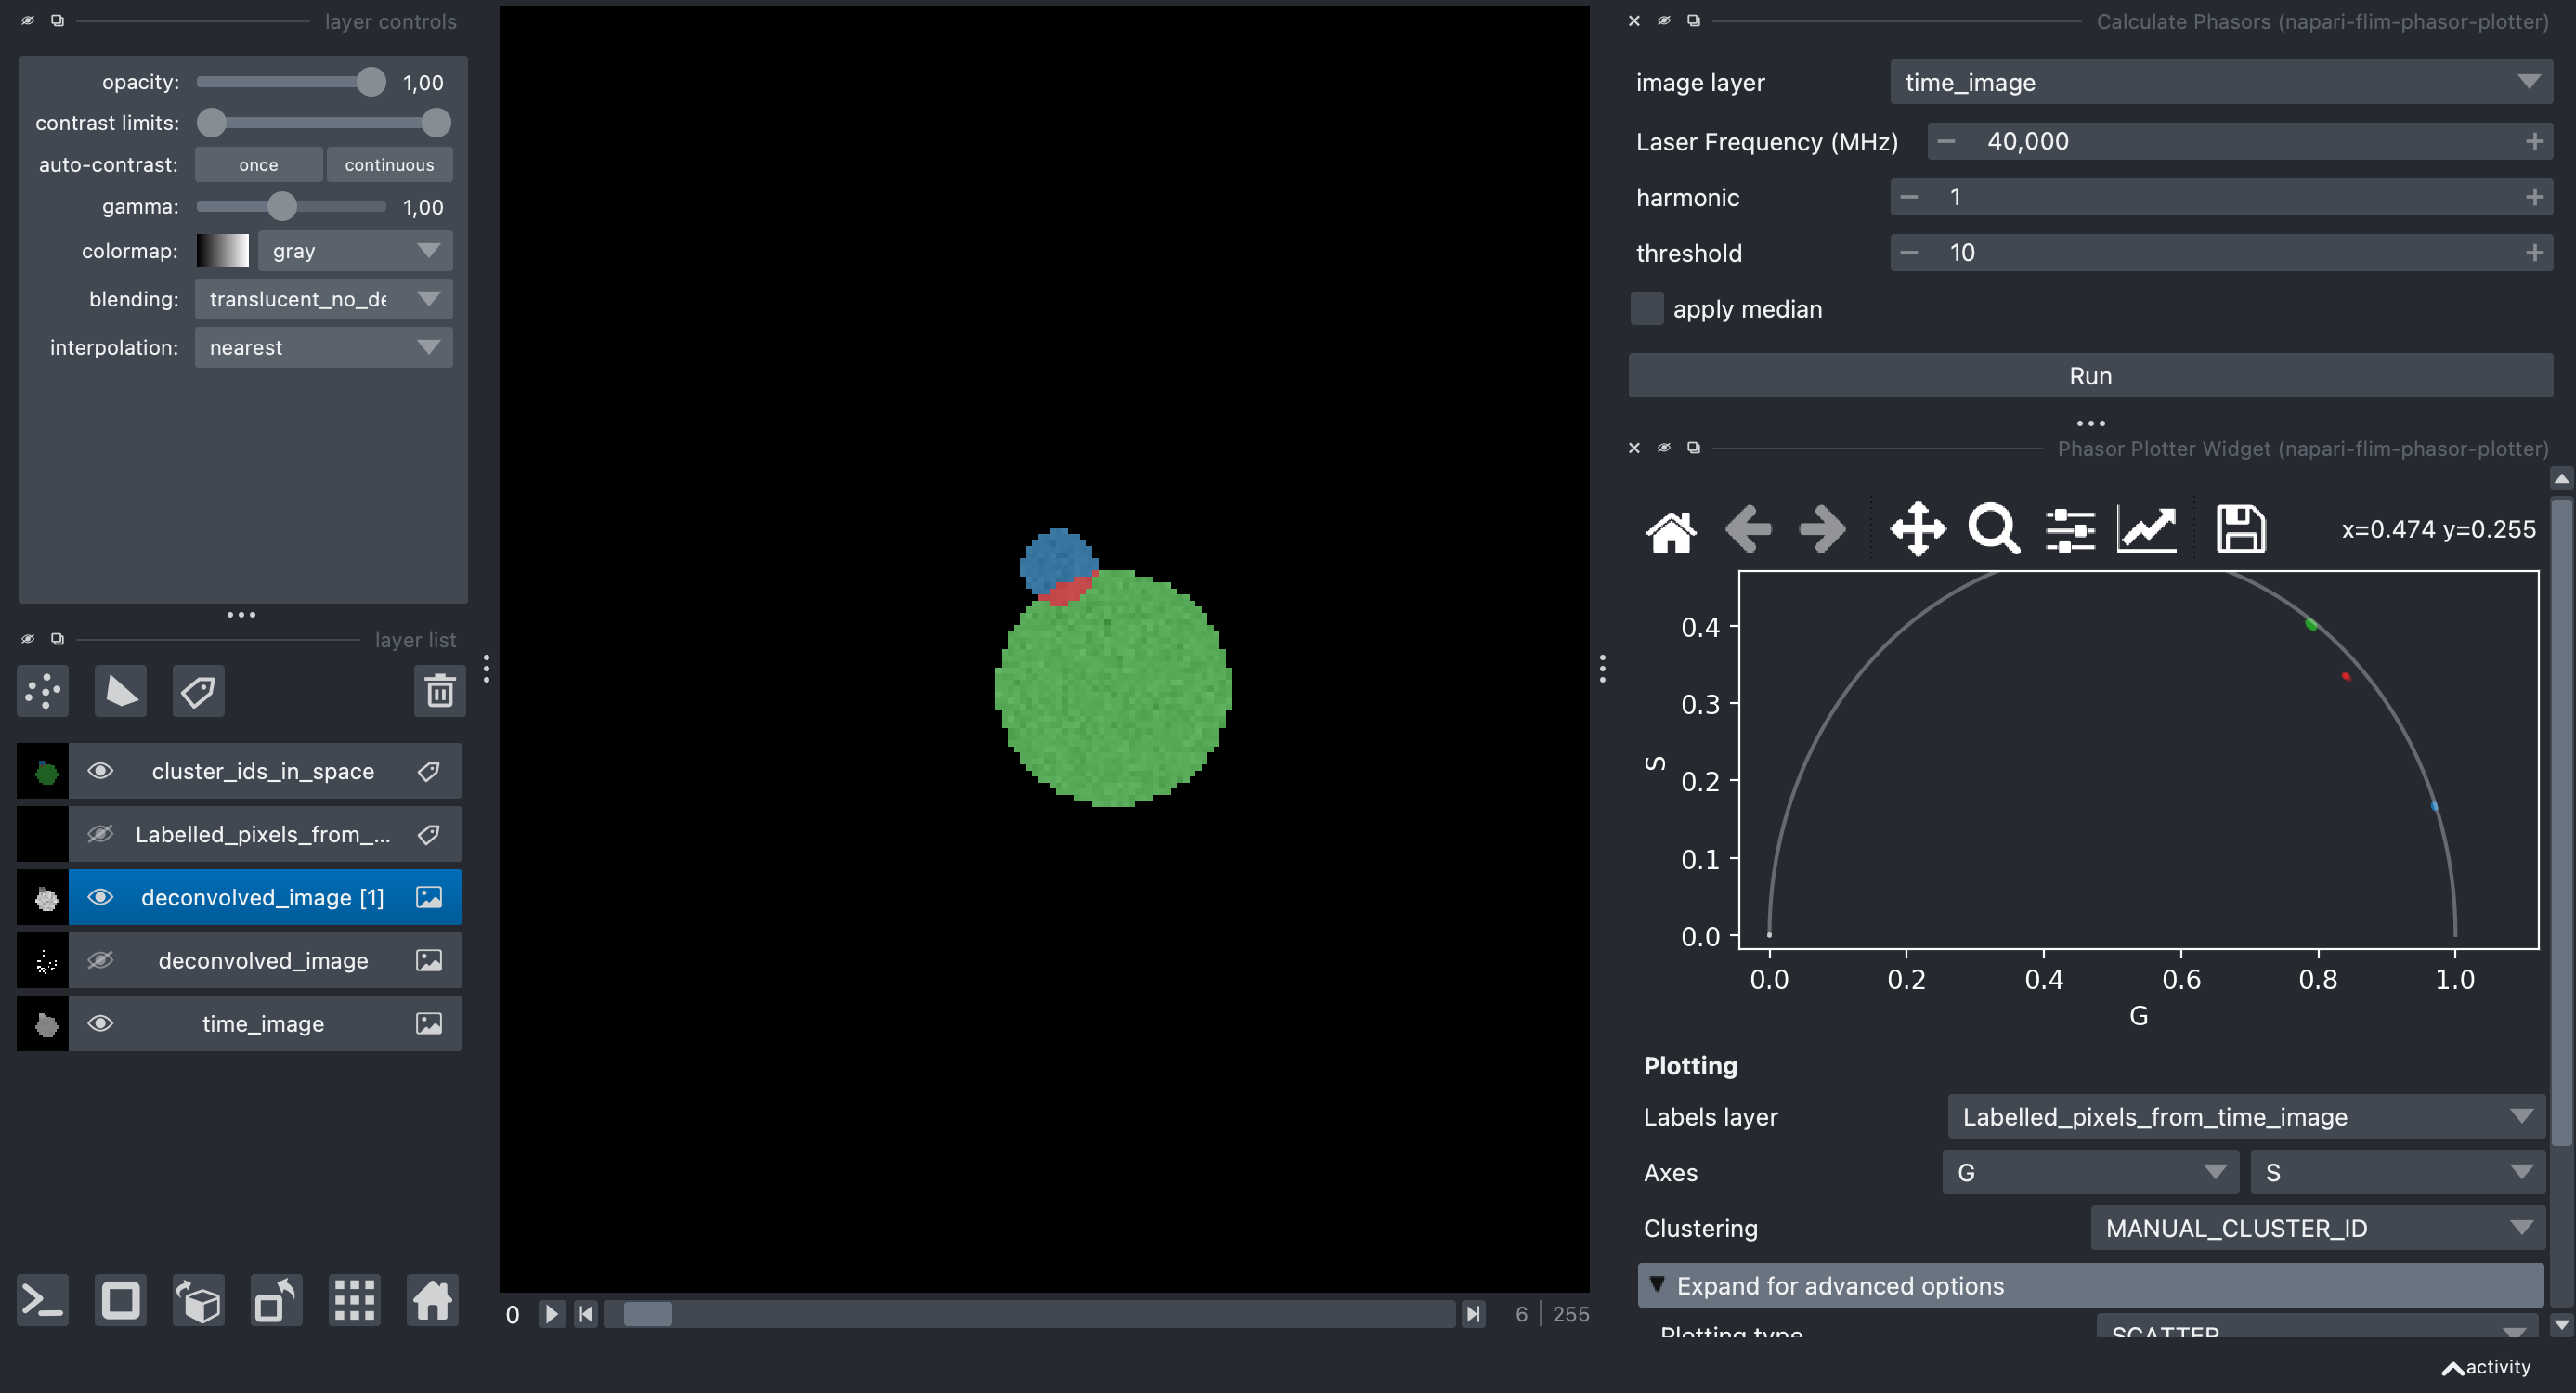

/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/napari_clusters_plotter/_plotter_utilities.py:261: RuntimeWarning: divide by zero encountered in double_scalars
  est_a = (np.max(data) - np.min(data)) / (2 * stats.iqr(data) / np.cbrt(len(data)))
Traceback (most recent call last):
  File "/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/napari_clusters_plotter/_plotter.py", line 229, in plotting_type_changed
    replot()
  File "/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/napari_clusters_plotter/_plotter.py", line 205, in replot
    self.run(
  File "/Users/lana/Documents/GitHub/napari-flim-phasor-plotter/src/napari_flim_phasor_plotter/_plotting.py", line 18, in run
    super().run(features=features,
  File "/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/napari_clusters_plotter/_plotter.py", line 760, in run
    estimate_number_bins(self.data_x),
  F

Selected measurements do not exist in layer's properties/features. The plot is not (re)drawn.
Selected measurements do not exist in layer's properties/features. The plot is not (re)drawn.
Selected measurements do not exist in layer's properties/features. The plot is not (re)drawn.
Selected measurements do not exist in layer's properties/features. The plot is not (re)drawn.
Selected measurements do not exist in layer's properties/features. The plot is not (re)drawn.
Selected measurements do not exist in layer's properties/features. The plot is not (re)drawn.


/Users/lana/Documents/GitHub/napari-flim-phasor-plotter/src/napari_flim_phasor_plotter/_widget.py:122: FutureWarning: Private attribute access ('Window._dock_widgets') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  value in napari_viewer.window._dock_widgets.items()]
/Users/lana/Documents/GitHub/napari-flim-phasor-plotter/src/napari_flim_phasor_plotter/_widget.py:128: FutureWarning: Private attribute access ('Window._dock_widgets') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  widgets = napari_viewer.window._dock_widgets['Phasor Plotter Widget (napari-flim-phasor-plotter)']
/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/napari_clusters_plotter/_plotter_utilities.py:261: RuntimeWarning: divide by zero encountered in double_scalars
  est_a = (np.max(data) - np.min(data)) / (2 * stats.iqr(data) / np.cbrt(len(data)

Selected measurements do not exist in layer's properties/features. The plot is not (re)drawn.
Selected measurements do not exist in layer's properties/features. The plot is not (re)drawn.


/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/napari_clusters_plotter/_plotter_utilities.py:261: RuntimeWarning: divide by zero encountered in double_scalars
  est_a = (np.max(data) - np.min(data)) / (2 * stats.iqr(data) / np.cbrt(len(data)))
Traceback (most recent call last):
  File "/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/napari_clusters_plotter/_plotter.py", line 229, in plotting_type_changed
    replot()
  File "/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/napari_clusters_plotter/_plotter.py", line 205, in replot
    self.run(
  File "/Users/lana/Documents/GitHub/napari-flim-phasor-plotter/src/napari_flim_phasor_plotter/_plotting.py", line 18, in run
    super().run(features=features,
  File "/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/napari_clusters_plotter/_plotter.py", line 760, in run
    estimate_number_bins(self.data_x),
  F

In [96]:
napari.utils.nbscreenshot(viewer)

## Turned into function

In [11]:
def deconvolve_lifetime_image(time_image, irf = None, iterations = 50):
    deconvolved_image = np.copy(time_image)
    for x,y in np.ndindex(time_image.shape[1],time_image.shape[2]):
        time_array = np.copy(time_image[:,x,y])
        derived_irf = reconstruct_irf(time_array)

        if np.sum(derived_irf) != 0:
            if irf == None:
                deconvolved_image[:,x,y] = get_deconvolved_decay(tcspc_array = time_array, irf = derived_irf, n_iterations = iterations)
            else:
                deconvolved_image[:,x,y] = get_deconvolved_decay(tcspc_array = time_array, irf = irf, n_iterations = iterations)
        else:
            continue
    return(deconvolved_image)

In [13]:
import napari
viewer = napari.Viewer()

viewer.add_image(time_image)
viewer.add_image(deconvolve_lifetime_image(time_image))

<Image layer 'Image' at 0x7f7dd92b03a0>

In [14]:
viewer.add_image(time_image)

<Image layer 'time_image' at 0x7f7ddf996220>